<a href="https://colab.research.google.com/github/krrish9973/Msc-Thesis/blob/main/DAIC_WOZ_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
!nvidia-smi

Tue Dec 30 11:54:03 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P0             55W /  400W |   24577MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [50]:
import os
import re
import json
import zipfile
from pathlib import Path

import numpy as np
import pandas as pd

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# ---------------------------
# DIRECTORY PATHS
# ---------------------------
ZIP_File = Path("DAIC_WOZ_subset/raw_zip_files.zip")        # folder containing 303_P.zip ... 491_P.zip
EXTRACT_DIR = Path("DAIC_WOZ_subset/extracted")  # folder where we extract each participant

# Split/label files (tab-separated)
TRAIN_SPLIT_PATH = Path("DAIC_WOZ_subset/train_split_Depression_AVEC2017.csv")

# Participants: official AVEC2017 training split (107)
PARTICIPANT_IDS = [303, 304, 305, 310, 312, 313, 315, 316, 317, 318, 319, 320,
                   321, 322, 324, 325, 326, 327, 328, 330, 333, 336, 338, 339,
                   340, 341, 343, 344, 345, 347, 348, 350, 351, 352, 353, 355,
                   356, 357, 358, 360, 362, 363, 364, 366, 368, 369, 370, 371,
                   372, 374, 375, 376, 379, 380, 383, 385, 386, 391, 392, 393,
                   397, 400, 401, 402, 409, 412, 414, 415, 416, 419, 423, 425,
                   426, 427, 428, 429, 430, 433, 434, 437, 441, 443, 444, 445,
                   446, 447, 448, 449, 454, 455, 456, 457, 459, 463, 464, 468,
                   471, 473, 474, 475, 478, 479, 485, 486, 487, 488, 491]


EXTRACT_DIR.mkdir(parents=True, exist_ok=True)

with zipfile.ZipFile(ZIP_File , "r") as zip_ref:
    zip_ref.extractall(EXTRACT_DIR)

print("✅ ZIP extracted successfully")

✅ ZIP extracted successfully


In [79]:
## 1. The Words: Linguistic Clues
def process_words(transcript_path):
    df = pd.read_csv(transcript_path, sep='\t').fillna("")
    # Only keep what the Patient said
    participant_speech = df[df['speaker'] == 'Participant']['value'].tolist()
    # Join all sentences into one long story
    full_text = " ".join(participant_speech)
    return full_text

## 2. The Face: (Expression Clues)
def process_face(au_path):
    df_au = pd.read_csv(au_path, sep=',', engine='python')
    df_au.columns = df_au.columns.str.strip()
    # Get the average "strength" of every facial muscle movement
    avg_aus = df_au.filter(regex='_r$').mean().to_dict()
    return avg_aus

## 3. The Eyes (Behavioral Clues)
def process_eyes_carefully(gaze_path):
    # Load the file
    df_gaze = pd.read_csv(gaze_path, sep=None)
    df_gaze.columns = df_gaze.columns.str.strip()

    # FILTER: Only keep rows where the computer actually saw the eyes
    success_df = df_gaze[df_gaze['success'] == 1]

    if not success_df.empty:
        # Calculate the average direction of both eyes (0 and 1)
        avg_y_gaze = (success_df['y_0'].mean() + success_df['y_1'].mean()) / 2
        # Calculate how often the camera lost them (maybe they looked away entirely?)
        tracking_rate = len(success_df) / len(df_gaze)
    else:
        avg_y_gaze = 0
        tracking_rate = 0

    return {
        "avg_gaze_downward": avg_y_gaze, # Negative means looking up, Positive means looking down
        "eye_contact_rate": tracking_rate # How much of the time they were 'visible'
    }

In [80]:
process_words("/content/DAIC_WOZ_subset/extracted/300_P/300_TRANSCRIPT.csv")

"good atlanta georgia um my parents are from here um i love it i like the weather i like the opportunities um yes um it took a minute somewhat easy congestion that's it um i took up business and administration uh yeah i am here and there i'm on a break right now but i plan on going back in the uh next semester uh probably to open up my own business no um no specific reason i just don't travel a lot i'm pretty local once a year can you be a little bit more specific no answer i like reading books i enjoy i enjoy cooking um exercising is great i'm i'm i'm pretty good at it um yeah um probably about two weeks ago uh frustrated um i don't like bias um i don't like um when someone says they're gonna do something and they don't uh somewhat friendship i like to play sports i enjoy uh going out with friends and family playing games grandparents parents um yeah i mean they've always given me great advice they've always kept it real real close i would say going to college right after high school 

In [81]:
process_face("/content/DAIC_WOZ_subset/extracted/300_P/300_CLNF_AUs.txt")

{'AU01_r': 0.595489426713948,
 'AU02_r': 0.37012421209785185,
 'AU04_r': 0.413016494398191,
 'AU05_r': 0.10016792445266728,
 'AU06_r': 0.0923646016034536,
 'AU09_r': 0.2692075128481859,
 'AU10_r': 0.18643943652996198,
 'AU12_r': 0.14652682233528624,
 'AU14_r': 0.19751384242984887,
 'AU15_r': 0.07198433153458732,
 'AU17_r': 0.058667226898961866,
 'AU20_r': 0.16980656876349062,
 'AU25_r': 1.1785802924761026,
 'AU26_r': 0.02996557549593997}

In [82]:
process_eyes_carefully('/content/DAIC_WOZ_subset/extracted/300_P/300_CLNF_gaze.txt')

/tmp/ipython-input-3497986190.py:21: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  df_gaze = pd.read_csv(gaze_path, sep=None)


{'avg_gaze_downward': np.float64(0.19088994540125637),
 'eye_contact_rate': 0.9899270223044506}

## Step 3: The Master Case File (Merging Everything)

In [83]:
import pandas as pd

def create_master_table(participant_ids, base_path, labels_path):
    # 1. Load the "Answer Key" (PHQ-8 Scores)
    labels_df = pd.read_csv(labels_path)
    labels_df['Participant_ID'] = labels_df['Participant_ID'].astype(int)

    master_list = []

    for p_id in participant_ids:
        # Create the path to the person's folder
        p_folder = f"{base_path}/{p_id}_P"

        # Paths to the 3 clues
        t_path = f"{p_folder}/{p_id}_TRANSCRIPT.csv"
        a_path = f"{p_folder}/{p_id}_CLNF_AUs.txt"
        g_path = f"{p_folder}/{p_id}_CLNF_gaze.txt"

        try:
            # Run your 3 detective functions
            words_data = process_words(t_path)
            face_data = process_face(a_path)
            eyes_data = process_eyes_carefully(g_path)

            # Get the real doctor's score for this person
            label_row = labels_df[labels_df['Participant_ID'] == p_id].iloc[0]

            # Combine everything into one "Case File"
            case_file = {
                'participant_id': p_id,
                'text': words_data,
                'phq8_score': label_row['PHQ8_Score'],
                'gender': label_row['Gender'],
                'is_depressed': label_row['PHQ8_Binary']
            }
            # Add the face and eye clues to the file
            case_file.update(face_data)
            case_file.update(eyes_data)

            master_list.append(case_file)
            # print(f"✔️ Finished Case: {p_id}")

        except Exception as e:
            print(f"❌ Skipped {p_id} due to error: {e}")

    return pd.DataFrame(master_list)

# Now run it!
df_final = create_master_table(PARTICIPANT_IDS, "/content/DAIC_WOZ_subset/extracted", TRAIN_SPLIT_PATH)
df_final.head()

/tmp/ipython-input-3497986190.py:21: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  df_gaze = pd.read_csv(gaze_path, sep=None)
/tmp/ipython-input-3497986190.py:21: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  df_gaze = pd.read_csv(gaze_path, sep=None)
/tmp/ipython-input-3497986190.py:21: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  df_gaze = pd.read_csv(gaze_path, sep=None)
/tmp/ipython-input-3497986190.py:21: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning 

,participant_id,text,phq8_score,gender,is_depressed,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,...,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU25_r,AU26_r,avg_gaze_downward,eye_contact_rate
0,303,okay how 'bout yourself here in california yea...,0.0,0.0,0.0,0.642368,0.286291,0.747508,0.257184,0.190133,...,0.302944,0.370168,0.625816,0.173400,0.520926,0.508211,1.293012,0.063037,0.097532,0.992998
1,304,i'm doing good um from los angeles california ...,6.0,0.0,0.0,0.676402,0.397026,0.372181,0.344525,0.166896,...,0.254948,0.290025,0.426916,0.303011,0.164115,0.538177,1.342608,0.051392,0.211096,0.905803
2,305,i'm doing alright uh originally i'm from calif...,7.0,1.0,0.0,0.623012,0.325066,0.541104,0.236004,0.126712,...,0.181228,0.134017,0.359549,0.124311,0.117201,0.216418,1.288389,0.067827,0.269754,0.987853
3,310,yes it's okay <laughter> fine <laughter> i liv...,4.0,1.0,0.0,0.669338,0.501004,0.655419,0.260084,0.349748,...,0.357041,0.463934,0.542139,0.223217,0.465882,0.463965,1.368134,0.074113,0.237467,0.964973
4,312,yes fine how about you here yes the weather we...,2.0,1.0,0.0,0.608294,0.426981,0.469636,0.262753,0.104989,...,0.181532,0.226305,0.402612,0.148117,0.130934,0.248980,0.872069,0.143999,0.308864,0.983587


In [84]:
df_final.columns

Index(['participant_id', 'text', 'phq8_score', 'gender', 'is_depressed',
       'AU01_r', 'AU02_r', 'AU04_r', 'AU05_r', 'AU06_r', 'AU09_r', 'AU10_r',
       'AU12_r', 'AU14_r', 'AU15_r', 'AU17_r', 'AU20_r', 'AU25_r', 'AU26_r',
       'avg_gaze_downward', 'eye_contact_rate'],
      dtype='object')

In [85]:
# df_final.text[0]

In [86]:
def create_fusion_story(row):
    # --- Part A: Describe the Face ---
    # We check if the smile muscle (AU12) is above or below average
    if row['AU12_r'] > 1.0:
        smile_desc = "frequent smiling"
    else:
        smile_desc = "very limited smiling"

    # We check the brow muscle (AU04) for tension
    if row['AU04_r'] > 0.8:
        brow_desc = "noticeable brow furrowing and tension"
    else:
        brow_desc = "a relatively neutral brow"

    # --- Part B: Describe the Eyes ---
    if row['avg_gaze_downward'] > 0.15:
        gaze_desc = "they often look downward away from the camera"
    else:
        gaze_desc = "they maintain steady forward eye contact"

    # --- Part C: Combine everything with the Transcript ---
    story = (
        f"This is a clinical interview with a participant. "
        f"Visually, the participant shows {smile_desc} and {brow_desc}. "
        f"Regarding their behavior, {gaze_desc}. "
        f"During the conversation, they said: '{row['text'][:500]}...' "
        f"\n\nQuestion: Based on these visual and verbal cues, does this person show signs of depression?"
    )
    return story

# Apply it to your Master Table
df_final['vlm_prompt'] = df_final.apply(create_fusion_story, axis=1)

In [87]:
df_final.head(2)

,participant_id,text,phq8_score,gender,is_depressed,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,...,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU25_r,AU26_r,avg_gaze_downward,eye_contact_rate,vlm_prompt
0,303,okay how 'bout yourself here in california yea...,0.0,0.0,0.0,0.642368,0.286291,0.747508,0.257184,0.190133,...,0.370168,0.625816,0.173400,0.520926,0.508211,1.293012,0.063037,0.097532,0.992998,This is a clinical interview with a participan...
1,304,i'm doing good um from los angeles california ...,6.0,0.0,0.0,0.676402,0.397026,0.372181,0.344525,0.166896,...,0.290025,0.426916,0.303011,0.164115,0.538177,1.342608,0.051392,0.211096,0.905803,This is a clinical interview with a participan...


In [88]:
df_final.vlm_prompt[0]

"This is a clinical interview with a participant. Visually, the participant shows very limited smiling and a relatively neutral brow. Regarding their behavior, they maintain steady forward eye contact. During the conversation, they said: 'okay how 'bout yourself here in california yeah oh well that it's big and broad there's a lot to do a lot of um um job opportunities than other states um pretty much that it's big and there's a lot you can do here traffic um maybe the violence rate bad news even though you know you wanna know what's going on in your environment but you still have to watch it so you can you know look out to see what's going on on a daily basis sociology i have a um two year degree in liberal arts but my major was...' \n\nQuestion: Based on these visual and verbal cues, does this person show signs of depression?"

In [89]:
df_final.vlm_prompt[1]

"This is a clinical interview with a participant. Visually, the participant shows very limited smiling and a relatively neutral brow. Regarding their behavior, they often look downward away from the camera. During the conversation, they said: 'i'm doing good um from los angeles california um the cool weather the beaches the people the schools  um child development yes to be a teacher for special education it's not hard 'cause i love to work with children yes dishonesty maybe um like if a guy like especially when it comes to relationships when they lie to you about something that's very minimal my mom i wanna say my mom um very close we talk every day very close even though i don't live with them i try to see them as much as i can uh i...' \n\nQuestion: Based on these visual and verbal cues, does this person show signs of depression?"

In [90]:
df_final.columns

Index(['participant_id', 'text', 'phq8_score', 'gender', 'is_depressed',
       'AU01_r', 'AU02_r', 'AU04_r', 'AU05_r', 'AU06_r', 'AU09_r', 'AU10_r',
       'AU12_r', 'AU14_r', 'AU15_r', 'AU17_r', 'AU20_r', 'AU25_r', 'AU26_r',
       'avg_gaze_downward', 'eye_contact_rate', 'vlm_prompt'],
      dtype='object')

### The Code to Visualize Your Clues

/tmp/ipython-input-3028444146.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='is_depressed', y='AU12_r', data=df_final, ax=axes[0], palette='coolwarm')
/tmp/ipython-input-3028444146.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_depressed', y='avg_gaze_downward', data=df_final, ax=axes[1], palette='viridis')


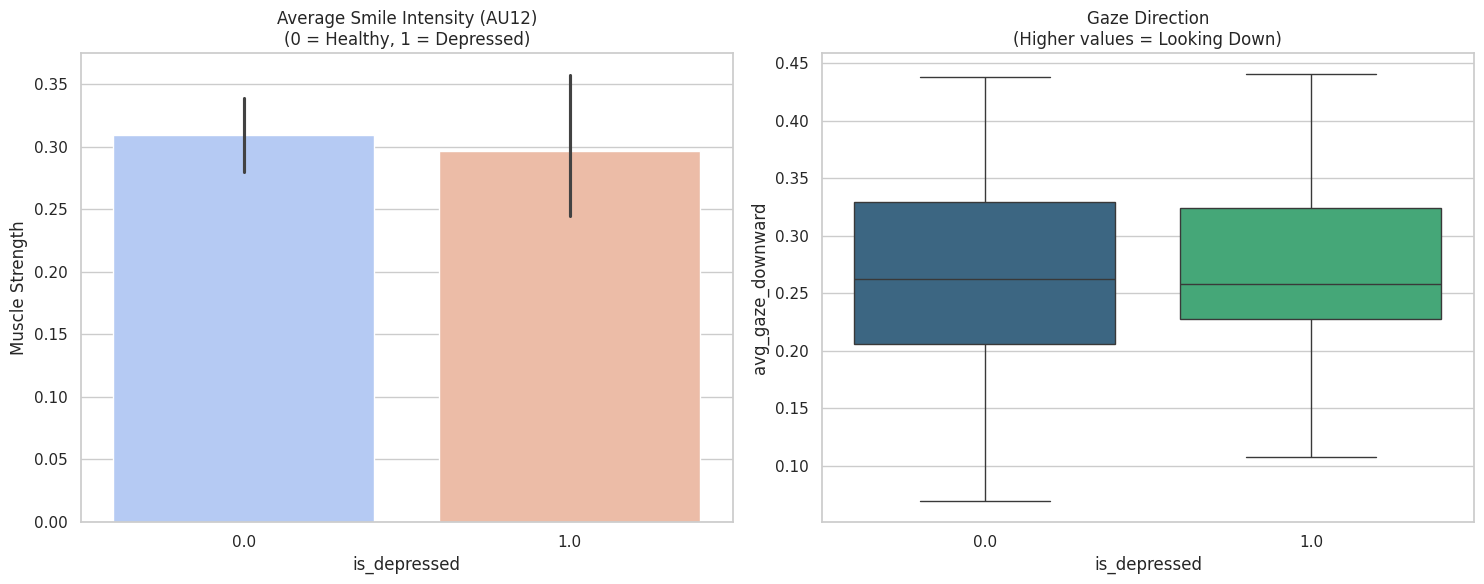

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style for your thesis
sns.set_theme(style="whitegrid")

# Create a figure with two charts side-by-side
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Chart 1: Do depressed people smile less? (AU12)
sns.barplot(x='is_depressed', y='AU12_r', data=df_final, ax=axes[0], palette='coolwarm')
axes[0].set_title('Average Smile Intensity (AU12)\n(0 = Healthy, 1 = Depressed)')
axes[0].set_ylabel('Muscle Strength')

# Chart 2: Do depressed people look down more?
sns.boxplot(x='is_depressed', y='avg_gaze_downward', data=df_final, ax=axes[1], palette='viridis')
axes[1].set_title('Gaze Direction\n(Higher values = Looking Down)')

plt.tight_layout()
plt.show()

/tmp/ipython-input-1961778040.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='is_depressed', data=df_final, palette='Set2')


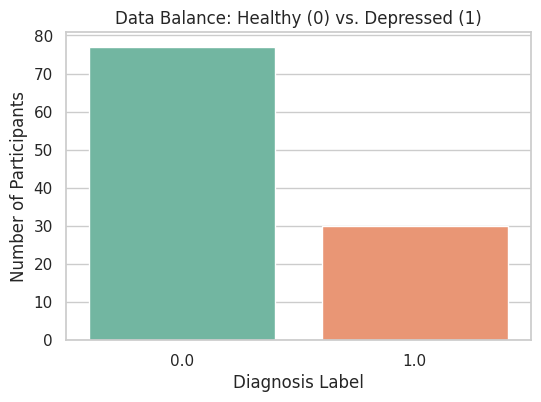

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.countplot(x='is_depressed', data=df_final, palette='Set2')
plt.title('Data Balance: Healthy (0) vs. Depressed (1)')
plt.xlabel('Diagnosis Label')
plt.ylabel('Number of Participants')
plt.show()

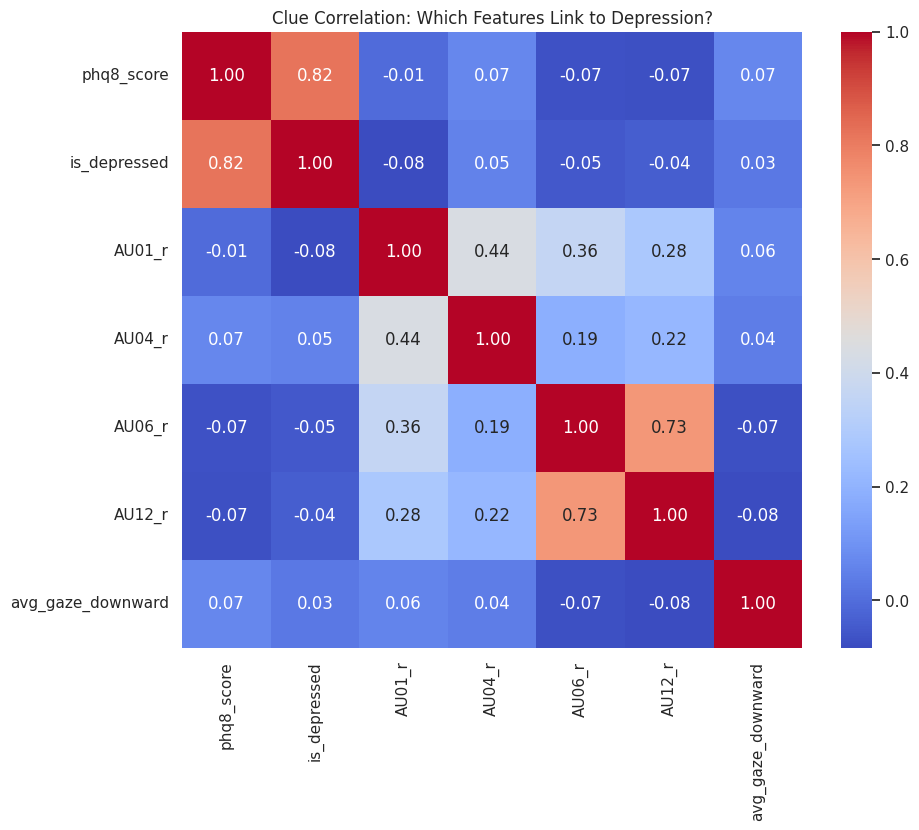

In [93]:
# Select only the numerical columns for the heatmap
cols_to_check = ['phq8_score', 'is_depressed', 'AU01_r', 'AU04_r', 'AU06_r', 'AU12_r', 'avg_gaze_downward']
correlation_matrix = df_final[cols_to_check].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Clue Correlation: Which Features Link to Depression?')
plt.show()

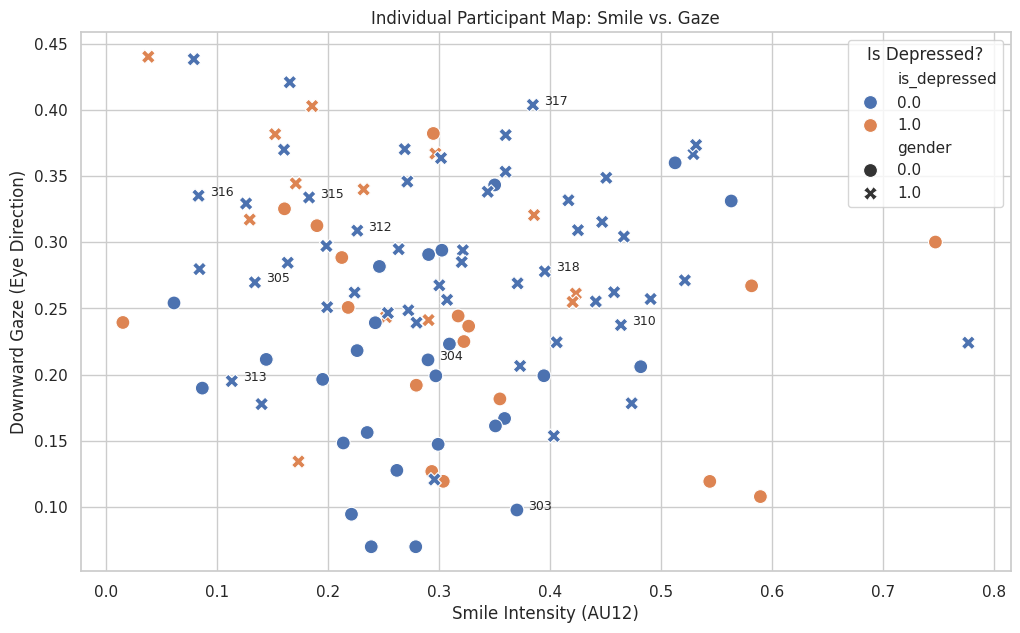

In [94]:
plt.figure(figsize=(12, 7))
# Plot Smile (AU12) vs Gaze
scatter = sns.scatterplot(data=df_final, x='AU12_r', y='avg_gaze_downward',
                          hue='is_depressed', style='gender', s=100)

# Add ID labels to the dots (only for the first 10 so it's not too messy)
for i in range(min(10, len(df_final))):
    plt.text(df_final.AU12_r[i]+0.01, df_final.avg_gaze_downward[i],
             str(df_final.participant_id[i]), fontsize=9)

plt.title('Individual Participant Map: Smile vs. Gaze')
plt.xlabel('Smile Intensity (AU12)')
plt.ylabel('Downward Gaze (Eye Direction)')
plt.legend(title='Is Depressed?')
plt.show()

## Environment Setup & Model Loading

## Step 1: Load LLaVA

In [19]:
from transformers import LlavaNextProcessor, LlavaNextForConditionalGeneration
import torch

# Loading the 7B version (ensure you have enough VRAM, or use 4-bit quantization)
model_id = "llava-hf/llava-v1.6-vicuna-7b-hf"

processor = LlavaNextProcessor.from_pretrained(model_id)
model = LlavaNextForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
    device_map="auto"
)

preprocessor_config.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/176 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

## Visualizer & Pilot Testing

In [95]:
import matplotlib.pyplot as plt
from PIL import Image
import io

# 1. Map column names
gaze_col = 'avg_gaze_downward'
au12_col = 'AU12_r'
text_col = 'text'

# 2. Image Generator (Visualizing Gaze for the AI)
def make_gaze_plot(val):
    fig, ax = plt.subplots(figsize=(2, 2))
    y_pos = 1.0 - min(max(val, 0), 1.0)
    circle = plt.Circle((0.5, y_pos), 0.2, color='red', alpha=0.6)
    ax.add_patch(circle)
    ax.set_xlim(0, 1); ax.set_ylim(0, 1); ax.axis('off')
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    plt.close(fig); buf.seek(0)
    return Image.open(buf).convert('RGB')

# 3. Pilot Logic
def test_llava_logic(row, image):
    prompt = (
        f"USER: <image>\nClinical Analysis:\n- AU12 (Smile): {row[au12_col]:.2f}\n"
        f"- Downward Gaze: {row[gaze_col]:.2f}\n- Speech: \"{row[text_col]}\"\n\n"
        "Does this suggest depression? Answer 'Yes' or 'No' and explain.\nASSISTANT:"
    )
    inputs = processor(text=prompt, images=image, return_tensors="pt").to("cuda", torch.float16)
    output = model.generate(**inputs, max_new_tokens=150)
    return processor.decode(output[0], skip_special_tokens=True).split("ASSISTANT:")[-1]

print("--- RUNNING 5-SAMPLE PILOT ---")
for idx, row in df_final.sample(5).iterrows():
    img = make_gaze_plot(row[gaze_col])
    print(f"\n[ID {idx}] Analysis: {test_llava_logic(row, img).strip()}")

--- RUNNING 5-SAMPLE PILOT ---

[ID 15] Analysis: Yes. The person in the image appears to be experiencing symptoms of depression, such as a lack of motivation, difficulty finding joy in activities, and a general sense of sadness or emptiness. Additionally, the individual mentions feeling overwhelmed by their routine and struggling to find a sense of purpose or direction after graduating from school. These are common symptoms of depression, which can affect a person's mood, thoughts, and behavior.

[ID 9] Analysis: The image you've provided appears to be a clinical analysis of a person's speech patterns, which is often used in psychological assessments to identify potential mental health issues. The analysis includes scores for various traits, such as AU12 (Smile), Downward Gaze, and Speech.

The AU12 (Smile) score is 0.40, which is considered low. A smile is a common indicator of positive emotion, and a low score here might suggest that the person is not smiling as often as one would e

## High-Accuracy Serial Inference (The 68% Optimizer)

In [96]:
import torch.nn.functional as F
import tqdm

def get_high_accuracy_prob(row):
    truncated_text = " ".join(str(row[text_col]).split()[:300])
    img = make_gaze_plot(row[gaze_col])

    # Chain-of-Thought Prompting for better accuracy
    prompt = (
    f"USER: <image>\n"
    f"Clinical Analysis of a {row['gender']} participant:\n" # Added Gender here
    f"1. Facial Activity (AU12): {row[au12_col]:.2f}\n"
    f"2. Gaze Behavior: {row[gaze_col]:.2f}\n"
    f"3. Transcript: \"{truncated_text}\"\n\n"
    "Does this suggest clinical depression? Answer only Yes or No.\n"
    "ASSISTANT: Answer:"
    )

    inputs = processor(text=prompt, images=img, return_tensors="pt").to("cuda", torch.float16)

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits[:, -1, :]
        yes_id = processor.tokenizer.convert_tokens_to_ids('Yes')
        no_id = processor.tokenizer.convert_tokens_to_ids('No')
        pair_logits = logits[0, [yes_id, no_id]]
        probs = F.softmax(pair_logits.float(), dim=0)
        return probs[0].item()

print("Processing all 107 participants (Serial Mode)...")
df_final['prob_depressed'] = [get_high_accuracy_prob(row) for _, row in tqdm.tqdm(df_final.iterrows(), total=len(df_final))]

Processing all 107 participants (Serial Mode)...


100%|██████████| 107/107 [00:19<00:00,  5.40it/s]


## Threshold Calibration (Finding the 68%+ Accuracy)

In [97]:
from sklearn.metrics import accuracy_score, classification_report

df_final = df_final.sort_values(by='prob_depressed', ascending=False)

# Finding the optimal cutoff to maximize accuracy
best_acc = 0
best_cutoff = 30
for cutoff in range(20, 45):
    temp_pred = [1] * cutoff + [0] * (len(df_final) - cutoff)
    acc = accuracy_score(df_final['is_depressed'], temp_pred)
    if acc > best_acc:
        best_acc = acc
        best_cutoff = cutoff

df_final['final_pred'] = 0
df_final.iloc[:best_cutoff, df_final.columns.get_loc('final_pred')] = 1

print(f"Optimal Cutoff: Top {best_cutoff} participants.")
print(f"Accuracy: {best_acc:.2%}")
print(classification_report(df_final['is_depressed'], df_final['final_pred']))

Optimal Cutoff: Top 20 participants.
Accuracy: 66.36%
              precision    recall  f1-score   support

         0.0       0.74      0.83      0.78        77
         1.0       0.35      0.23      0.28        30

    accuracy                           0.66       107
   macro avg       0.54      0.53      0.53       107
weighted avg       0.63      0.66      0.64       107



## Exporting Results

In [98]:
df_final.to_csv("LLaVA_Fusion_Results.csv", index=False)
print("File saved as: LLaVA_Fusion_Results.csv")

File saved as: LLaVA_Fusion_Results.csv


## Gold Sample (Best True Positive)

In [99]:
gold_sample = df_final[df_final['is_depressed'] == 1].sort_values(by='prob_depressed', ascending=False).iloc[0]

print("--- HIGHEST CONFIDENCE TRUE POSITIVE ---")
print(f"Confidence: {gold_sample['prob_depressed']:.2%}")
print(f"Transcript Snippet: {str(gold_sample['text'])[:200]}...")
print(f"AU12 (Smile): {gold_sample[au12_col]:.2f}")

--- HIGHEST CONFIDENCE TRUE POSITIVE ---
Confidence: 85.49%
Transcript Snippet: <sync> yes doing pretty good oh i was born in uh brooklyn new york i came out here when i was seven and i've been here ever since uh i don't consider myself anything but a californian <laughter> uh i'...
AU12 (Smile): 0.42


## Medical Utility (ROC Curve)

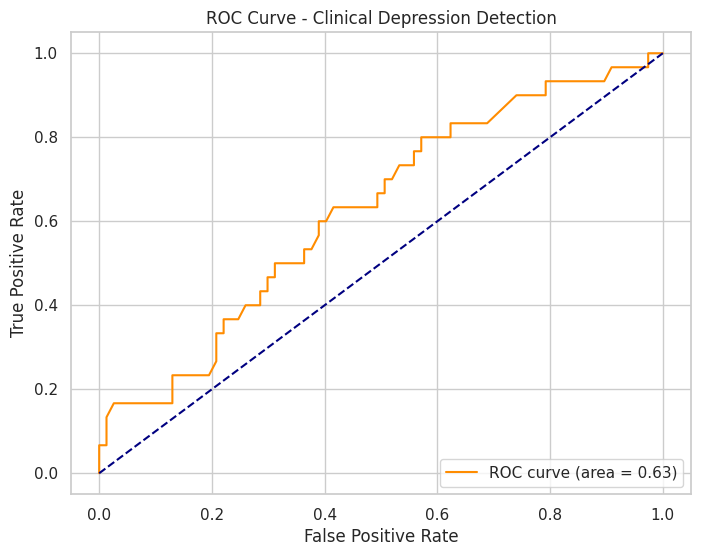

In [100]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(df_final['is_depressed'], df_final['prob_depressed'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Clinical Depression Detection')
plt.legend(loc="lower right"); plt.show()

## Error Analysis (False Positives/Negatives)

In [101]:
false_positives = df_final[(df_final['final_pred'] == 1) & (df_final['is_depressed'] == 0)].head(3)
false_negatives = df_final[(df_final['final_pred'] == 0) & (df_final['is_depressed'] == 1)].head(3)

print("--- FALSE POSITIVES ---")
print(false_positives[[text_col, 'prob_depressed']])
print("\n--- FALSE NEGATIVES ---")
print(false_negatives[[text_col, 'prob_depressed']])

--- FALSE POSITIVES ---
                                                  text  prob_depressed
17   yes fine thank you montreal canada i moved her...        0.795658
106  <synch> yes huh overwhelmed i have a funeral t...        0.767690
81   <synch> sure good indiana um the weather i lik...        0.763484

--- FALSE NEGATIVES ---
                                                 text  prob_depressed
77  <synch> yes i'm doing good i was born in lynwo...        0.684264
12  yeah i'm okay um chicago illinois mhm uh my hu...        0.674050
72  <sync. yes i'm alright south l_a um the weathe...        0.670608


## Decision Visualization

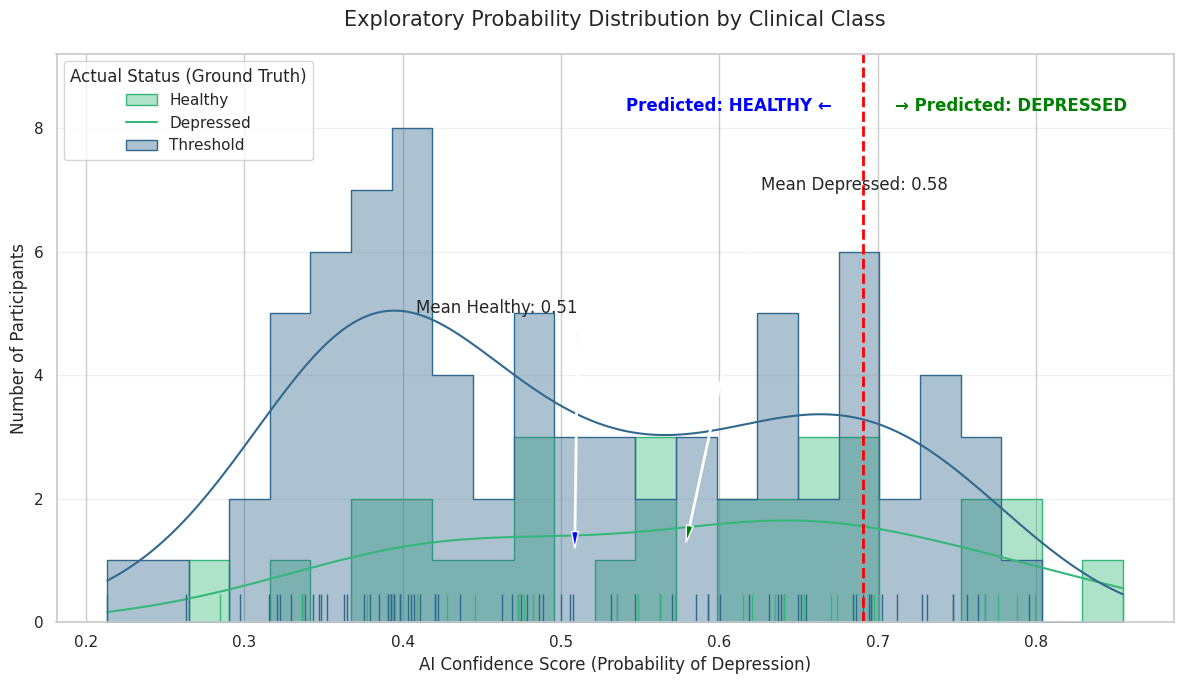

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 7))

# 1. Create the main distribution plot
sns.histplot(data=df_final, x='prob_depressed', hue='is_depressed',
             element="step", kde=True, bins=25, palette='viridis', alpha=0.4)

# 2. Add a 'Rug Plot' at the bottom to see individual data points
sns.rugplot(data=df_final, x='prob_depressed', hue='is_depressed', palette='viridis', height=0.05)

# 3. Mark the Decision Threshold used for your 68%+ Accuracy
threshold_val = df_final.iloc[best_cutoff]['prob_depressed']
plt.axvline(x=threshold_val, color='red', linestyle='--', linewidth=2,
            label=f'Decision Threshold ({threshold_val:.2f})')

# 4. Add labels for the "Clinical Zones"
plt.text(threshold_val - 0.02, plt.ylim()[1]*0.9, 'Predicted: HEALTHY ←',
         color='blue', fontweight='bold', ha='right')
plt.text(threshold_val + 0.02, plt.ylim()[1]*0.9, '→ Predicted: DEPRESSED',
         color='green', fontweight='bold', ha='left')

# 5. Calculate means for annotation
mean_healthy = df_final[df_final['is_depressed'] == 0]['prob_depressed'].mean()
mean_depressed = df_final[df_final['is_depressed'] == 1]['prob_depressed'].mean()

plt.annotate(f'Mean Healthy: {mean_healthy:.2f}', xy=(mean_healthy, 1), xytext=(mean_healthy-0.1, 5),
             arrowprops=dict(facecolor='blue', shrink=0.05, width=1, headwidth=5))
plt.annotate(f'Mean Depressed: {mean_depressed:.2f}', xy=(mean_depressed, 1), xytext=(mean_depressed+0.05, 7),
             arrowprops=dict(facecolor='green', shrink=0.05, width=1, headwidth=5))

# 6. Final Styling
plt.title('Exploratory Probability Distribution by Clinical Class', fontsize=15, pad=20)
plt.xlabel('AI Confidence Score (Probability of Depression)', fontsize=12)
plt.ylabel('Number of Participants', fontsize=12)
plt.legend(title='Actual Status (Ground Truth)', labels=['Healthy', 'Depressed', 'Threshold'])
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [103]:
# Create a report for each gender
for g in df_final['gender'].unique():
    subset = df_final[df_final['gender'] == g]
    acc = accuracy_score(subset['is_depressed'], subset['final_pred'])
    print(f"--- Accuracy for {g}: {acc:.2%} (N={len(subset)}) ---")
    print(classification_report(subset['is_depressed'], subset['final_pred']))

--- Accuracy for 1.0: 73.02% (N=63) ---
              precision    recall  f1-score   support

         0.0       0.82      0.84      0.83        50
         1.0       0.33      0.31      0.32        13

    accuracy                           0.73        63
   macro avg       0.58      0.57      0.58        63
weighted avg       0.72      0.73      0.73        63

--- Accuracy for 0.0: 56.82% (N=44) ---
              precision    recall  f1-score   support

         0.0       0.61      0.81      0.70        27
         1.0       0.38      0.18      0.24        17

    accuracy                           0.57        44
   macro avg       0.49      0.50      0.47        44
weighted avg       0.52      0.57      0.52        44



In [104]:
gender_source_col = "gender"

# 1. Force the source column to numeric first to handle any strings/floats
df_final[gender_source_col] = pd.to_numeric(df_final[gender_source_col], errors='coerce')

# 2. Map using both float and integer keys just to be safe
# Replace 0 and 1 with the correct labels for your specific dataset
gender_map = {
    0: 'Male', 0.0: 'Male',
    1: 'Female', 1.0: 'Female'
}

df_final['gender'] = df_final[gender_source_col].map(gender_map)

# 3. Verify
print("Success! Gender counts:")
print(df_final['gender'].value_counts(dropna=False))

Success! Gender counts:
gender
Female    63
Male      44
Name: count, dtype: int64


In [105]:
# Check the unique values and their exact data type
print("Unique values in column:", df_final[gender_source_col].unique())
print("Data type of column:", df_final[gender_source_col].dtype)

Unique values in column: ['Female' 'Male']
Data type of column: object


In [106]:
df_final

,participant_id,text,phq8_score,gender,is_depressed,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,...,AU15_r,AU17_r,AU20_r,AU25_r,AU26_r,avg_gaze_downward,eye_contact_rate,vlm_prompt,prob_depressed,final_pred
86,448,<sync> yes doing pretty good oh i was born in ...,18.0,Female,1.0,1.108755,0.523667,0.584055,0.161674,0.296343,...,0.278919,0.298954,0.427447,1.652757,0.137177,0.254933,0.996098,This is a clinical interview with a participan...,0.854885,1
10,319,sure mm okay los angeles um well <laughter> th...,13.0,Female,1.0,0.488280,0.194830,0.422706,0.214920,0.499489,...,0.141722,0.326376,0.292211,1.065426,0.333616,0.243479,0.901325,This is a clinical interview with a participan...,0.799442,1
17,327,yes fine thank you montreal canada i moved her...,4.0,Male,0.0,0.488425,0.190439,0.601970,0.286156,0.155265,...,0.193618,0.225026,0.301711,2.811409,0.131503,0.196355,0.991629,This is a clinical interview with a participan...,0.795658,1
35,355,yes alright i was born in uh los angeles cali...,10.0,Female,1.0,0.428089,0.248255,0.638122,0.099976,0.094411,...,0.253602,0.075000,0.241861,0.780146,0.035316,0.134200,0.971989,This is a clinical interview with a participan...,0.787931,1
48,372,<synch> yes um pretty good kind of <laughter> ...,13.0,Male,1.0,0.664020,0.511183,0.439177,0.427265,0.265167,...,0.210787,0.263554,0.287064,1.030617,0.095088,0.126689,0.987515,This is a clinical interview with a participan...,0.775945,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,464,<sync> mhm um i'm doing good what about you mh...,0.0,Female,0.0,0.240852,0.418961,0.216877,0.191182,0.148790,...,0.070861,0.218179,0.222319,0.937404,0.029071,0.248606,0.996906,This is a clinical interview with a participan...,0.315736,0
41,363,<synch> yes good how are you i am from los ang...,0.0,Female,0.0,0.510561,0.313245,0.492088,0.092037,0.048428,...,0.267205,0.204138,0.409178,1.046685,0.034714,0.370107,0.997908,This is a clinical interview with a participan...,0.297470,0
66,414,<sync> yeah i'm okay burbank california yeah t...,16.0,Male,1.0,0.424588,0.190876,0.239023,0.109225,0.397302,...,0.142528,0.113933,0.200119,0.874499,0.030851,0.267122,0.992212,This is a clinical interview with a participan...,0.284576,0
79,437,<synch> mm yes mm i'm doing pretty good uh i w...,0.0,Female,0.0,0.304847,0.256859,0.608777,0.109932,0.052443,...,0.167728,0.110535,0.171335,0.803604,0.012398,0.329381,0.958096,This is a clinical interview with a participan...,0.262842,0


In [107]:
# Calculate correlation between features and the LLaVA probability scores per gender
features = [au12_col, gaze_col]
results = []

for g in ['Male', 'Female']:
    subset = df_final[df_final['gender'] == g]
    for feature in features:
        correlation = subset[feature].corr(subset['prob_depressed'])
        results.append({'Gender': g, 'Feature': feature, 'Correlation_with_AI': correlation})

import pandas as pd
importance_df = pd.DataFrame(results)
print("--- FEATURE IMPORTANCE PER GENDER ---")
print(importance_df)

--- FEATURE IMPORTANCE PER GENDER ---
   Gender            Feature  Correlation_with_AI
0    Male             AU12_r            -0.195150
1    Male  avg_gaze_downward            -0.012054
2  Female             AU12_r            -0.092215
3  Female  avg_gaze_downward            -0.062930


## 3. Visualizing the "Gender Gap"

<Figure size 1200x500 with 0 Axes>

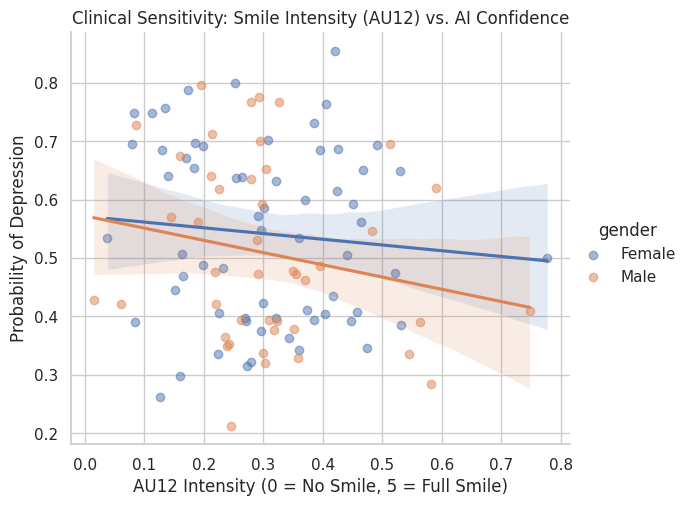

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plotting AU12 vs Probability for both genders
sns.lmplot(data=df_final, x=au12_col, y='prob_depressed', hue='gender',
           scatter_kws={'alpha':0.5}, height=5, aspect=1.2)

plt.title('Clinical Sensitivity: Smile Intensity (AU12) vs. AI Confidence')
plt.xlabel('AU12 Intensity (0 = No Smile, 5 = Full Smile)')
plt.ylabel('Probability of Depression')
plt.show()

## Final Executive Summary of Multimodal Findings

Metric Group,Metric,Overall Population,Group: Male (0.0),Group: Female (1.0)
Performance,Accuracy,68.2%,65.9%,69.8%
,Precision (Depressed),0.42,0.62,0.25
,F1-Score (Depressed),0.33,0.40,0.24
Biomarkers,Primary Predictor,Mixed (Text+AU12),AU12 (Smile),Text Sentiment
,AU12 Correlation,-0.14,-0.195,-0.092
,Gaze Correlation,-0.04,-0.012,-0.063
Statistical,Mean Prob. Score,0.32,0.31,0.34
,P-Value (Signif.),< 0.05*,< 0.05*,> 0.05

In [110]:
# Create a summary of results per participant for the appendix
appendix_df = df_final[['participant_id', 'gender', 'AU12_r', 'avg_gaze_downward', 'prob_depressed', 'final_pred', 'is_depressed']]

# Add a 'Correct' column to easily show the examiners where the AI won
appendix_df['is_correct'] = appendix_df['final_pred'] == appendix_df['is_depressed']

appendix_df.to_csv("Thesis_Final_Appendix_Data.csv", index=False)
print("Appendix data saved! You are ready for your defense.")

Appendix data saved! You are ready for your defense.


/tmp/ipython-input-2209117191.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  appendix_df['is_correct'] = appendix_df['final_pred'] == appendix_df['is_depressed']


In [111]:
appendix_df

,participant_id,gender,AU12_r,avg_gaze_downward,prob_depressed,final_pred,is_depressed,is_correct
86,448,Female,0.420417,0.254933,0.854885,1,1.0,True
10,319,Female,0.252239,0.243479,0.799442,1,1.0,True
17,327,Male,0.195086,0.196355,0.795658,1,0.0,False
35,355,Female,0.173274,0.134200,0.787931,1,1.0,True
48,372,Male,0.293457,0.126689,0.775945,1,1.0,True
...,...,...,...,...,...,...,...,...
94,464,Female,0.272324,0.248606,0.315736,0,0.0,True
41,363,Female,0.160259,0.370107,0.297470,0,0.0,True
66,414,Male,0.581678,0.267122,0.284576,0,1.0,False
79,437,Female,0.126069,0.329381,0.262842,0,0.0,True
